In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score ,mean_absolute_error
from sklearn import preprocessing
from sklearn.discriminant_analysis import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
import matplotlib as mpl
import seaborn as sns
import joblib


Google Colab 載入drive

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Read CSV

In [2]:
#讀資料

# def detect_encoding(file_path):
#     rawdata = open(file_path, 'rb').read()
#     result = chardet.detect(rawdata)
#     return result['encoding']


# encoding = detect_encoding(file_path)
# df = pd.read_csv(file_path, encoding=encoding)

#NoPreSale 沒有預售屋
file_path = './model/cleaning/500m/tph_500m_clean_NoPreSale.csv'
df = pd.read_csv(file_path, encoding='big5')
tph_housing_df = df.drop(columns=['Identifier','Type'])


# tph_housing_df.head(5)



<Axes: xlabel='TransactionYear', ylabel='Count'>

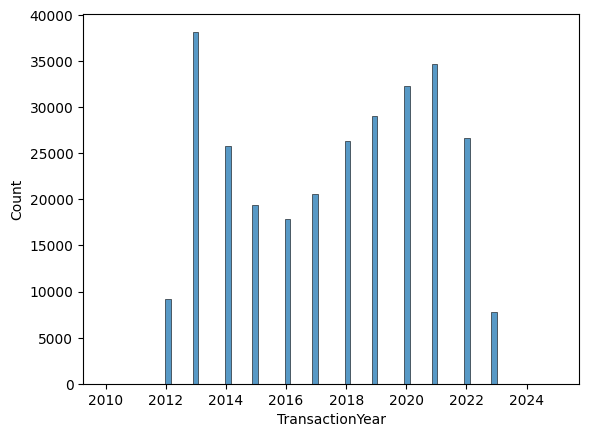

In [3]:

# 繪製新北市房屋交易年分直方圖


sns.histplot(tph_housing_df['TransactionYear'], binrange=(2010,2025))


<Axes: xlabel='Price_per_Area', ylabel='Count'>

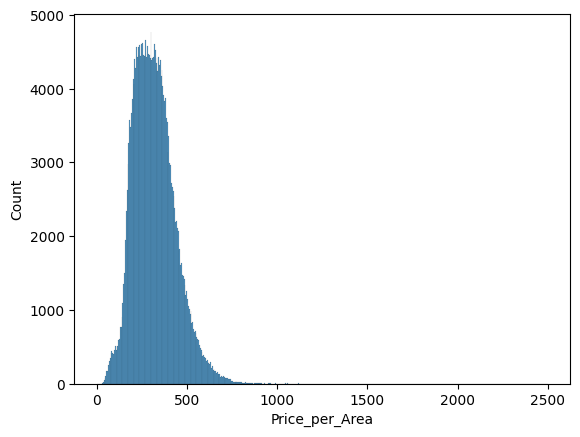

In [4]:
# 繪製北市房屋每坪房價(K/坪)直方圖

sns.histplot(tph_housing_df['Price_per_Area'],binrange=(0,2500))


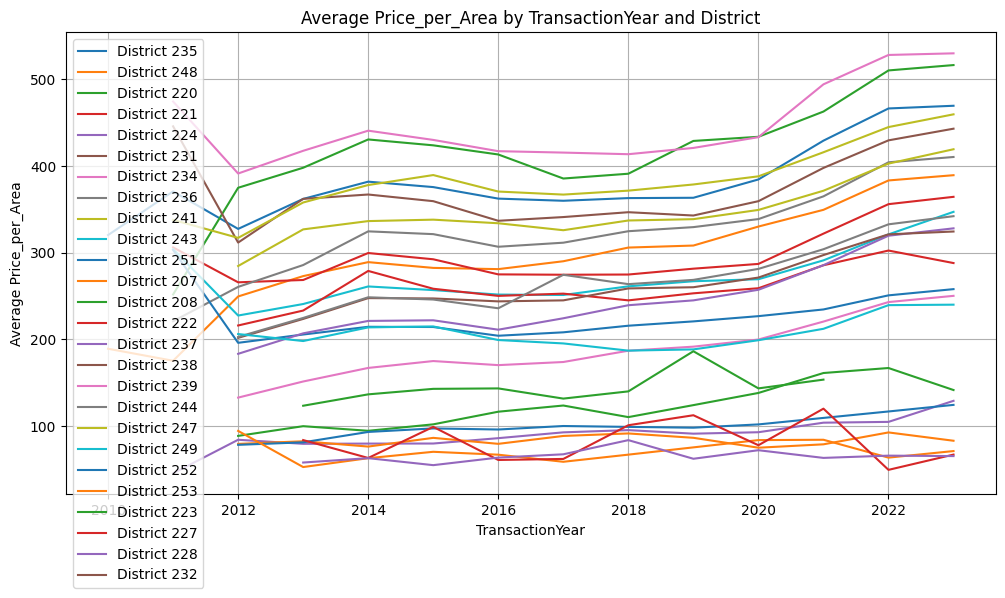

In [5]:
grouped_data = df.groupby(['TransactionYear', 'District'])['Price_per_Area'].mean().reset_index()

# 绘制线图
plt.figure(figsize=(12, 6))  # 设置图形大小
for district in grouped_data['District'].unique():
    data = grouped_data[grouped_data['District'] == district]
    plt.plot(data['TransactionYear'], data['Price_per_Area'], label=f'District {district}')

plt.xlabel('TransactionYear')  # X轴标签
plt.ylabel('Average Price_per_Area')  # Y轴标签
plt.title('Average Price_per_Area by TransactionYear and District')  # 图表标题
plt.legend()  # 添加图例
plt.grid(True)  # 添加网格线
plt.show()  # 显示图形

In [6]:
# 使用groupby計算每個'District'的交易次數
TPE_district_transaction_counts = tph_housing_df['District'].value_counts().reset_index()

# 將結果重命名為合適的列名
TPE_district_transaction_counts.columns = ['District', '交易次數']

# 將結果按交易次數降序排序
TPE_transaction_counts = TPE_district_transaction_counts.sort_values(by='交易次數', ascending=False)

# 使用 sum 函數計算總交易筆數
TPE_total_transactions = TPE_transaction_counts['交易次數'].sum()  # 修正此行

# 列印每個 District 的交易筆數
print(TPE_transaction_counts)

# 列印總交易筆數
print("總交易筆數:", TPE_total_transactions)

    District   交易次數
0        251  43725
1        248  35363
2        220  25412
3        241  23796
4        235  23098
5        221  22035
6        231  22026
7        244  15474
8        236  15334
9        247  13563
10       234  10247
11       238   8935
12       237   8640
13       239   5353
14       249   4673
15       243   4132
16       252   2604
17       222   1399
18       208    779
19       207    711
20       224    481
21       228     59
22       253     48
23       223     46
24       227     29
25       232      1
總交易筆數: 287963


In [7]:
#刪除交易量低於4000筆的區
columns_to_drop = ["D_232", "D_233", "D_227","D_223","D_253","D_228",
                   "D_224","D_208","D_207","D_222","D_252"]


tph_housing_df = tph_housing_df[~(tph_housing_df[columns_to_drop] == 1).any(axis=1)]

# 使用 Pandas 删除这些行
tph_housing_df = tph_housing_df.drop(columns=columns_to_drop)



繪製HeatMap相關矩陣

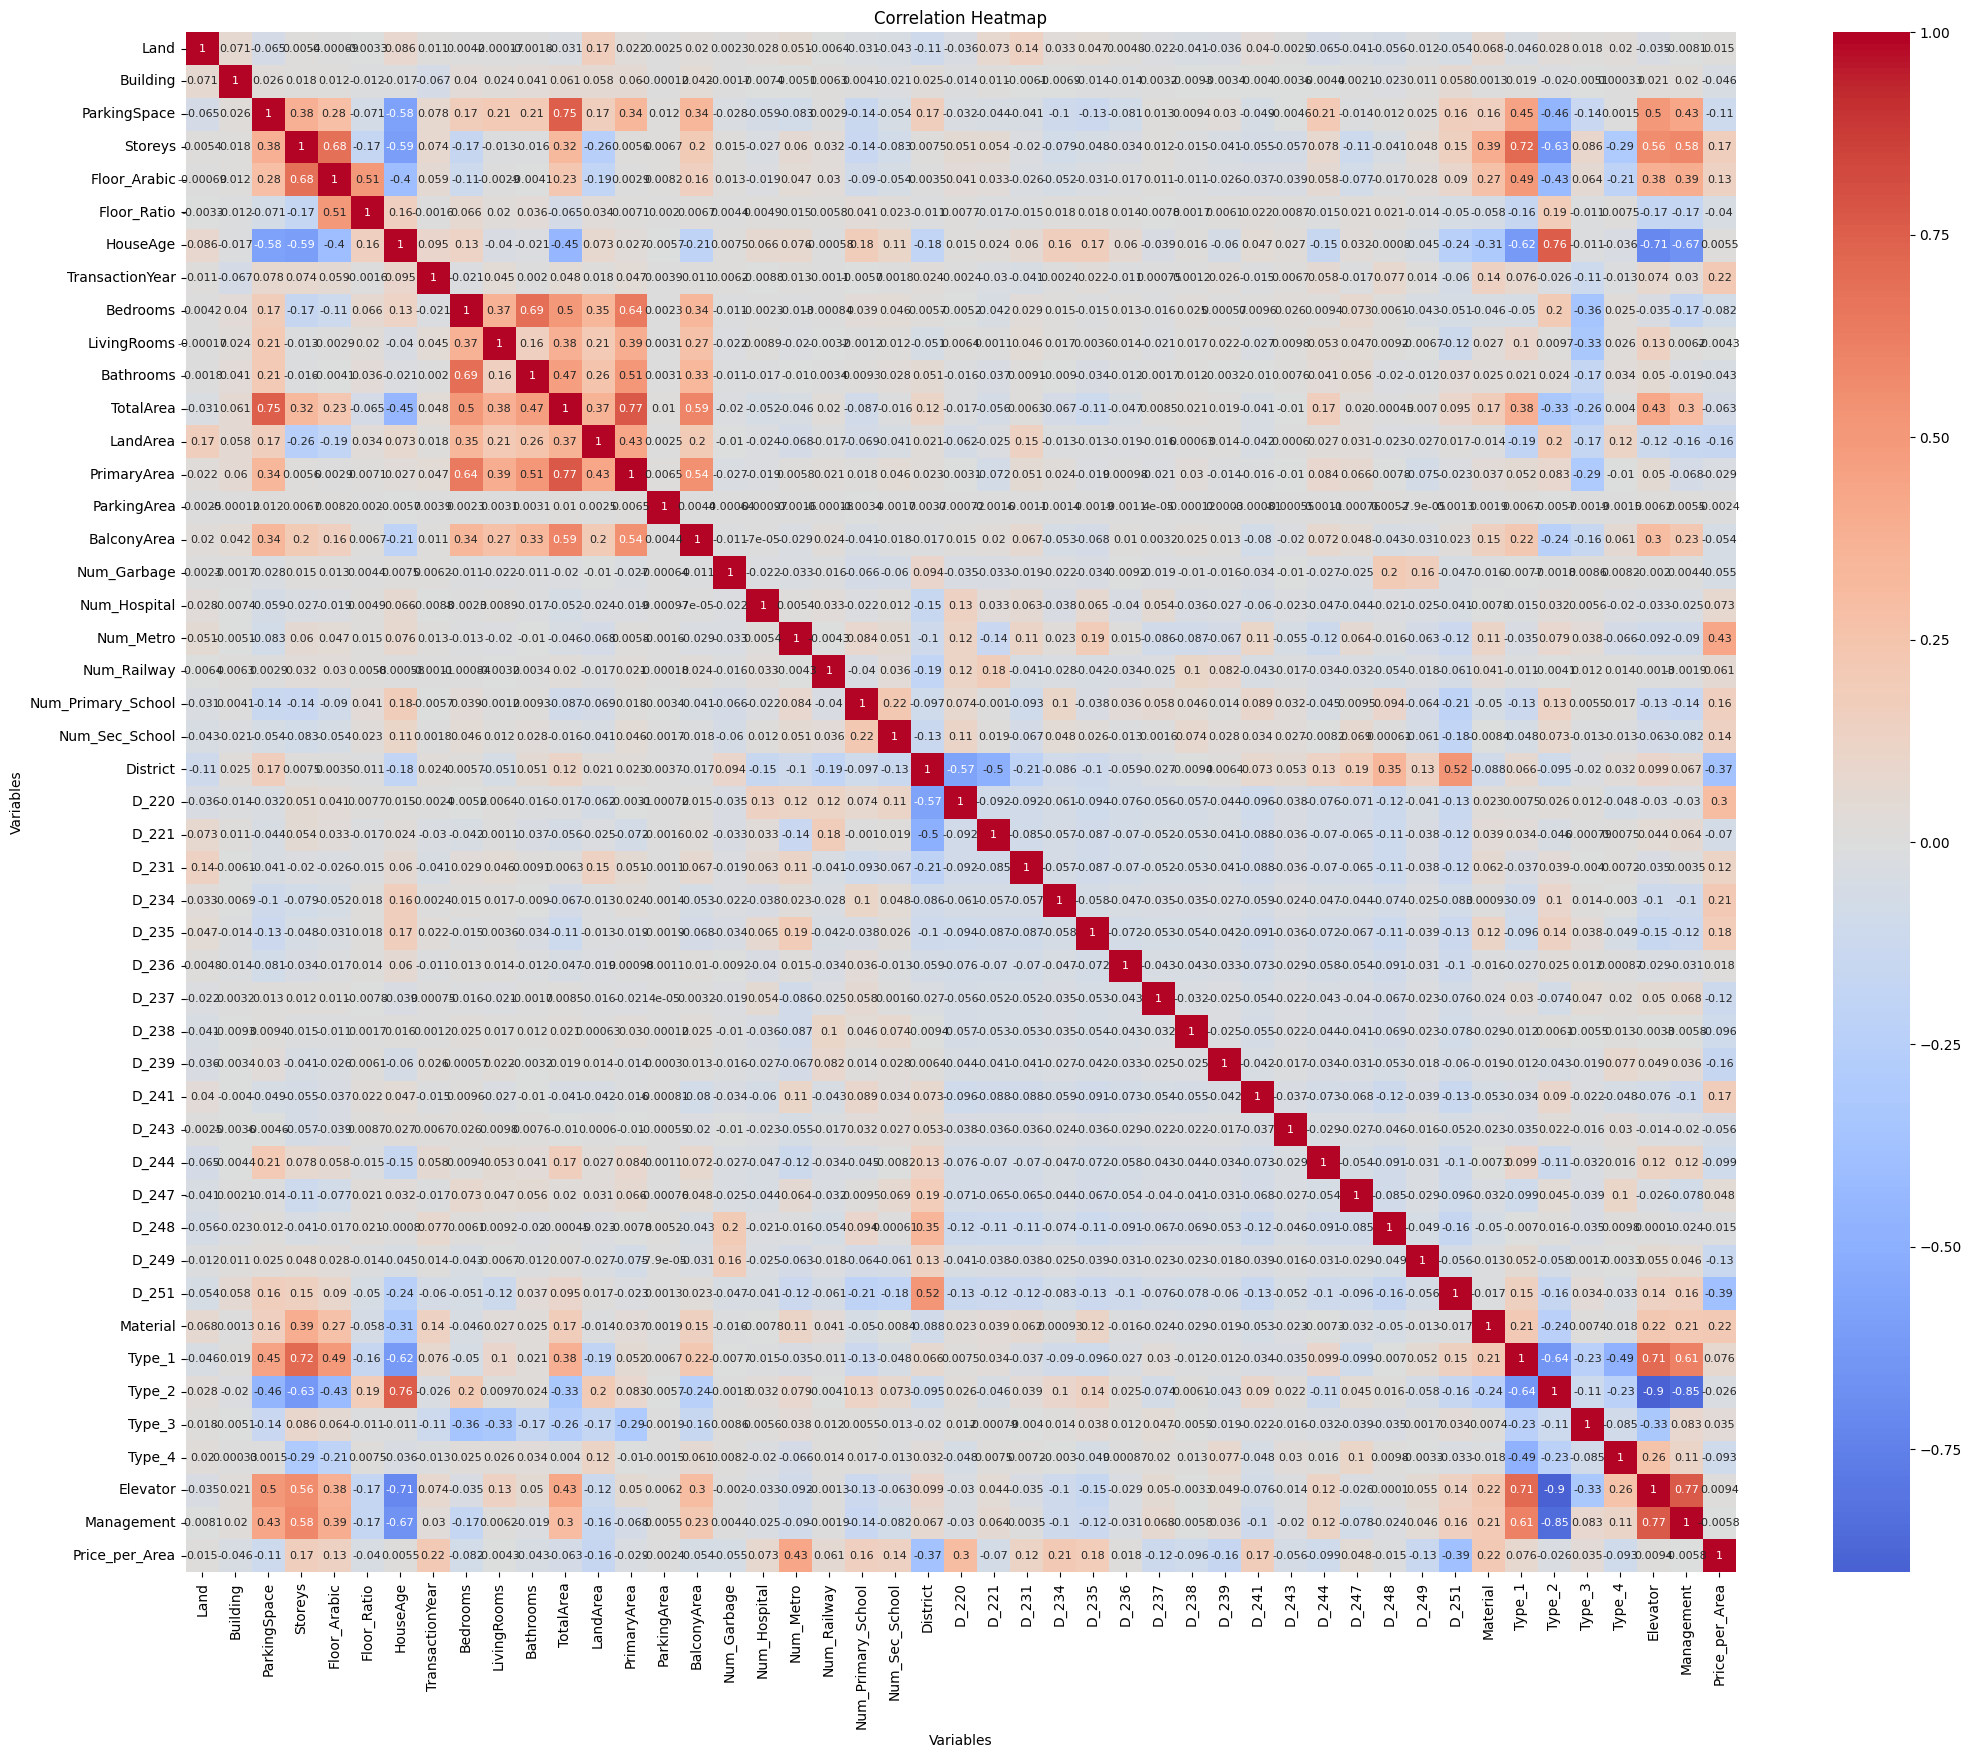

In [8]:
# drop TotalArea
# tph_housing_df=tph_housing_df.drop(df.columns[24:36], axis=1)
# tph_housing_df = tph_housing_df.drop(columns=['Land','Building','Storeys','Height','LandArea','PrimaryArea','ParkingArea','BalconyArea'])
tph_housing_df = tph_housing_df.drop(columns=['TotalPrice(k)'])
tph_housing_df.describe()

# 計算相關性矩陣
df_corr = tph_housing_df.corr()

# 設置圖形大小
plt.figure(figsize=(25, 20))

# 調整顏色映射，例如使用 "coolwarm" 色彩映射
sns.heatmap(df_corr, center=0, annot=True, cmap="coolwarm",
            annot_kws={"size": 8})  # 設定相關係數文字大小為 8

# 添加標題和標籤
plt.rcParams['font.family'] = 'Arial Unicode MS'
plt.title("Correlation Heatmap")
plt.xlabel("Variables")
plt.ylabel("Variables")

plt.show()

Lasso
Ridge
ElasticNet

In [9]:
# 分割訓練集和測試集


tph_housing_X = tph_housing_df.drop(columns=['Price_per_Area'])  # X變數，排除房屋價格列
tph_housing_y = tph_housing_df['Price_per_Area']  # Y變數，房屋每坪價格
print("tph_housing_X shape: {}".format(tph_housing_X.shape))
print("tph_housing_y shape: {}".format(tph_housing_y.shape))

tph_housing_X_train, tph_housing_X_test, tph_housing_y_train, tph_housing_y_test = train_test_split(tph_housing_X, tph_housing_y, test_size=0.2, random_state=10)

# 標準化
scaler = StandardScaler()

# 對X_train進行標準化
X_train_scaled = scaler.fit_transform(tph_housing_X_train)

# 使用相同的標準化器對X_test進行標準化
X_test_scaled = scaler.transform(tph_housing_X_test)

#Build model
model = linear_model.Lasso(alpha=0.1)
# model = linear_model.Ridge(alpha=1.0)
# model = linear_model.ElasticNet(alpha=1.0, l1_ratio=0.5)

# Train the model using the training sets
model.fit(X_train_scaled, tph_housing_y_train)



# Make predictions using the testing set
tph_housing_y_pred = model.predict(X_test_scaled)

# # The coefficients
# print('Coefficients: {}\n'.format(model.coef_))
# Print每個變數的係數
for i, coef in enumerate(model.coef_):
    print("變數 {} 的係數: {:.2f}".format(tph_housing_X.columns[i], coef))

# The mean squared error
print("Mean squared error: {}".format((mean_squared_error(tph_housing_y_test, tph_housing_y_pred))))
# Explained variance score: 1 is perfect prediction
print('R2 score: {}'.format(r2_score(tph_housing_y_test, tph_housing_y_pred)))
print('number of model coef: {}'.format(np.sum(model.coef_ != 0)))


tph_housing_X shape: (281806, 46)
tph_housing_y shape: (281806,)
變數 Land 的係數: -4.22
變數 Building 的係數: -0.02
變數 ParkingSpace 的係數: -16.84
變數 Storeys 的係數: -4.90
變數 Floor_Arabic 的係數: 23.75
變數 Floor_Ratio 的係數: -18.18
變數 HouseAge 的係數: -24.83
變數 TransactionYear 的係數: 26.35
變數 Bedrooms 的係數: -5.96
變數 LivingRooms 的係數: -1.20
變數 Bathrooms 的係數: 5.47
變數 TotalArea 的係數: 5.26
變數 LandArea 的係數: -7.07
變數 PrimaryArea 的係數: 2.01
變數 ParkingArea 的係數: -0.10
變數 BalconyArea 的係數: -5.83
變數 Num_Garbage 的係數: -1.87
變數 Num_Hospital 的係數: 4.22
變數 Num_Metro 的係數: 25.06
變數 Num_Railway 的係數: 6.13
變數 Num_Primary_School 的係數: 8.05
變數 Num_Sec_School 的係數: 3.83
變數 District 的係數: -17.18
變數 D_220 的係數: 13.70
變數 D_221 的係數: -14.78
變數 D_231 的係數: 8.45
變數 D_234 的係數: 22.25
變數 D_235 的係數: 12.70
變數 D_236 的係數: 0.00
變數 D_237 的係數: -14.68
變數 D_238 的係數: -10.28
變數 D_239 的係數: -18.47
變數 D_241 的係數: 15.13
變數 D_243 的係數: -3.74
變數 D_244 的係數: -9.91
變數 D_247 的係數: 7.71
變數 D_248 的係數: -0.00
變數 D_249 的係數: -12.52
變數 D_251 的係數: -31.49
變數 Material 的係數: 3.92
變數 Type_1 

選擇區


In [10]:
# # 選擇 'District' 等於 'A' 的行
# mask = tph_housing_df['District'] == 116

# # # 使用遮罩篩選 DataFrame，獲得只包含 'District' 為 'A' 的行
# model_df = tph_housing_df[mask]

# # model_df=tph_housing_df

# print("model_rows shape: {}".format(model_df.shape))


# print(model_df)



In [11]:
model_df = tph_housing_df.drop(columns=['Land','Building','Storeys','Floor_Ratio','LandArea','PrimaryArea','ParkingArea','BalconyArea','District'])
print("model_df shape: {}".format(model_df.shape))
print(model_df.columns)

model_df shape: (281806, 38)
Index(['ParkingSpace', 'Floor_Arabic', 'HouseAge', 'TransactionYear',
       'Bedrooms', 'LivingRooms', 'Bathrooms', 'TotalArea', 'Num_Garbage',
       'Num_Hospital', 'Num_Metro', 'Num_Railway', 'Num_Primary_School',
       'Num_Sec_School', 'D_220', 'D_221', 'D_231', 'D_234', 'D_235', 'D_236',
       'D_237', 'D_238', 'D_239', 'D_241', 'D_243', 'D_244', 'D_247', 'D_248',
       'D_249', 'D_251', 'Material', 'Type_1', 'Type_2', 'Type_3', 'Type_4',
       'Elevator', 'Management', 'Price_per_Area'],
      dtype='object')


RandomForest


In [12]:
# 分割訓練集和測試集

tph_housing_X = model_df.drop(columns=['Price_per_Area'])  # X變數，排除房屋價格列
tph_housing_y = model_df['Price_per_Area']  # Y變數，房屋價格

print("tpe_housitph_housing_Xng_X shape: {}".format(tph_housing_X.shape))
print("tph_housing_y shape: {}".format(tph_housing_y.shape))

# tph_housing_X_train, tph_housing_X_test, tph_housing_y_train, tph_housing_y_test = train_test_split(tph_housing_X, tph_housing_y, test_size=0.2, random_state=42)

tph_housing_X_train, tph_housing_X_temp, tph_housing_y_train, tph_housing_y_temp = train_test_split(tph_housing_X, tph_housing_y, test_size=0.3, random_state=42)
tph_housing_X_val, tph_housing_X_test, tph_housing_y_val, tph_housing_y_test = train_test_split(tph_housing_X_temp, tph_housing_y_temp, test_size=0.5, random_state=42)

# 標準化器
scaler = StandardScaler()

# 對X_train進行標準化
X_train_scaled = scaler.fit_transform(tph_housing_X_train)

# 使用相同的標準化對X_test進行標準化
X_test_scaled = scaler.transform(tph_housing_X_test)

# 隨機森林回歸模型
rf_model = RandomForestRegressor(n_estimators=500,max_depth=7,n_jobs=-1,
    random_state=33)  # 設置隨機森林參數

# 在訓練集上訓練模型
rf_model.fit(tph_housing_X_train, tph_housing_y_train)


# Make predictions using the val set
tph_housing_y_pred = rf_model.predict(tph_housing_X_val)

# 計算均方誤差（MSE）
# 計算R²分數
mse = mean_squared_error(tph_housing_y_val, tph_housing_y_pred)
r2 = r2_score(tph_housing_y_val, tph_housing_y_pred)
mae = mean_absolute_error(tph_housing_y_val, tph_housing_y_pred)

# 使用验证集来评估模型性能
print("Validation Set Performance:")
print(f"Mean Squared Error: {mse}")
print(f"R² Score: {r2}")
print(f"MAE: {mae}")

# Make predictions using the testing set
y_test_pred = rf_model.predict(tph_housing_X_test)

mse_test = mean_squared_error(tph_housing_y_test, y_test_pred)
r2_test = r2_score(tph_housing_y_test, y_test_pred)
mae_test = mean_absolute_error(tph_housing_y_test, y_test_pred)
# 使用测试集来最终评估模型性能
print("\nTest Set Performance:")
print(f"Mean Squared Error (MSE): {mse_test}")
print(f"R² Score: {r2_test}")
print(f"Mean Absolute Error (MAE): {mae_test}")


tpe_housitph_housing_Xng_X shape: (281806, 37)
tph_housing_y shape: (281806,)
Validation Set Performance:
Mean Squared Error: 5461.9073923597625
R² Score: 0.5754146280844186
MAE: 56.22513875332338

Test Set Performance:
Mean Squared Error (MSE): 5401.579076363365
R² Score: 0.5765288005015423
Mean Absolute Error (MAE): 55.92352540014712


In [13]:
# 分割訓練集和測試集

tph_housing_X = model_df.drop(columns=['Price_per_Area'])  # X變數，排除房屋價格列
tph_housing_y = model_df['Price_per_Area']  # Y變數，房屋價格

print("tph_housing_X shape: {}".format(tph_housing_X.shape))
print("tph_housing_y shape: {}".format(tph_housing_y.shape))

# tph_housing_X_train, tph_housing_X_test, tph_housing_y_train, tph_housing_y_test = train_test_split(tph_housing_X, tph_housing_y, test_size=0.2, random_state=42)
tph_housing_X_train, tph_housing_X_temp, tph_housing_y_train, tph_housing_y_temp = train_test_split(tph_housing_X, tph_housing_y, test_size=0.3, random_state=42)
tph_housing_X_val, tph_housing_X_test, tph_housing_y_val, tph_housing_y_test = train_test_split(tph_housing_X_temp, tph_housing_y_temp, test_size=0.5, random_state=42)

# 標準化器
scaler = StandardScaler()

# 對X_train進行標準化
X_train_scaled = scaler.fit_transform(tph_housing_X_train)

# 使用相同的標準化對X_test進行標準化
X_test_scaled = scaler.transform(tph_housing_X_test)

# XGBooste回歸模型
xgb_model = XGBRegressor(n_estimators=500,max_depth= 7,n_jobs = -1,
    learning_rate = 0.1 ,random_state=33)  # 設XGBooster參數

# 在訓練集上訓練模型
xgb_model.fit(tph_housing_X_train, tph_housing_y_train)

# Make predictions using the val set
tph_housing_y_pred = xgb_model.predict(tph_housing_X_val)

# 計算均方誤差（MSE）
# 計算R²分數
mse = mean_squared_error(tph_housing_y_val, tph_housing_y_pred)
r2 = r2_score(tph_housing_y_val, tph_housing_y_pred)
mae = mean_absolute_error(tph_housing_y_val, tph_housing_y_pred)

# 使用验证集来评估模型性能
print("Validation Set Performance:")
print(f"Mean Squared Error: {mse}")
print(f"R² Score: {r2}")
print(f"MAE: {mae}")

# Make predictions using the testing set
y_test_pred = xgb_model.predict(tph_housing_X_test)

mse_test = mean_squared_error(tph_housing_y_test, y_test_pred)
r2_test = r2_score(tph_housing_y_test, y_test_pred)
mae_test = mean_absolute_error(tph_housing_y_test, y_test_pred)
# 使用测试集来最终评估模型性能
print("\nTest Set Performance:")
print(f"Mean Squared Error (MSE): {mse_test}")
print(f"R² Score: {r2_test}")
print(f"Mean Absolute Error (MAE): {mae_test}")


tph_housing_X shape: (281806, 37)
tph_housing_y shape: (281806,)
Validation Set Performance:
Mean Squared Error: 2173.2731158036277
R² Score: 0.8310590224509542
MAE: 33.67520843333486

Test Set Performance:
Mean Squared Error (MSE): 2147.866729823336
R² Score: 0.8316122586409523
Mean Absolute Error (MAE): 33.52306525825723


儲存model

In [14]:
joblib.dump(xgb_model, './model/cleaning/model_v1/xgb_model_tph_all_500m.pkl')

['./model/cleaning/model_v1/xgb_model_tph_all_500m.pkl']